#Install dependencies
#pip install numpy scipy matplotlib opencv-python scikit-image deepinv h5py


#Setup and Imports:

In [5]:
#!/usr/bin/env python3
# ==============================================================
# SKOOP-RED demo script
#
# Required dependencies (install via pip):
#   pip install numpy scipy matplotlib opencv-python scikit-image deepinv
#
# For PyTorch: install the correct wheel for your system (CPU or CUDA):
#   https://pytorch.org/get-started/locally/
#
# Optional:
#   pip install h5py    # only needed if you save/load .h5 datasets
#
# Notes:
# - Tested with Python >=3.9, PyTorch >=1.12, CUDA 11.6/11.8.
# - deepinv provides pretrained denoisers (downloaded automatically).
# - Use text.usetex=False unless LaTeX is installed.
# ==============================================================

import os
import time
import cv2
import h5py
import numpy as np
import scipy.fftpack
import matplotlib
import matplotlib.pyplot as plt

from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

import torch
import torch.nn.functional as F

# deepinv library for pretrained denoisers
from deepinv.models import DnCNN, DRUNet, GSDRUNet, DiffUNet

plt.style.use('default')

# ---- Matplotlib config ----
# --------- Device and Plot Style ---------
device = 'cuda' if torch.cuda.is_available() else 'cpu'
plt.style.use('default')
plt.rcParams.update({
    'text.latex.preamble': r'\usepackage{amsmath} \usepackage{amssymb} \usepackage{amsfonts}',
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'font.size': 28,
    'axes.labelsize': 28,
    'axes.titlesize': 28,
    'xtick.labelsize': 25,
    'ytick.labelsize': 25,
    'legend.fontsize': 30,
    'lines.linewidth': 3.5,
    'font.family': 'serif',
    'savefig.dpi': 600,
    'text.usetex': False,    #'text.usetex': True requires a LaTeX installation on the system.
})

torch.manual_seed(0); np.random.seed(0) #Reproducibility
device = 'cuda' if torch.cuda.is_available() else 'cpu'


#Parameters:

In [6]:
# -------------------------
# demo params
# -------------------------
img_path = '/home/shraddha/.dotnet/Set10C/3.png'   # Path to input image
# NOTE: if you change image size, ensure dimensions are even and reasonable for 4x4 pooling and DCT.
# Very small images (e.g. <8 px) will cause pooling / DCT to fall back to safe defaults.
iterations = 2500
gamma_init = 1.25
lam = 0.4
noise_std = 0 / 255.0
koopman_window = 30      # w (per paper)
koopman_every = 10       # r (per paper)
gamma_min = 0.01 * gamma_init

#Forward Operator:

In [7]:

# ---- Load Image ----
img = cv2.imread(img_path, cv2.IMREAD_COLOR)
if img is None:
    raise FileNotFoundError(f"Image not found: {img_path}")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = img.astype(np.float32) / 255.0

# --- Force even size for easy downsampling ---
H, W = img.shape[:2]
H_even, W_even = H // 2 * 2, W // 2 * 2
if (H_even != H) or (W_even != W):
    print(f"Input image shape {img.shape} is not even, cropping to ({H_even}, {W_even})")
    img = img[:H_even, :W_even]
H, W = img.shape[:2]

x_true = torch.tensor(img).permute(2,0,1).unsqueeze(0).to(device)
img_np = img

# Bicubic initialization with alignment:
# -------------------------------------
# We upsample the low-resolution (LR) measurement using bicubic interpolation.
# Because the forward model downsamples by always picking the *top-left pixel*
# of each 2×2 patch, a half-pixel spatial shift is introduced.
# This function corrects that shift by applying a sub-pixel grid adjustment
# after bicubic interpolation, ensuring the initialization z0 is properly aligned.

def upsample_bicubic_aligned(y_lr, scale_factor=2):
    N, C, H, W = y_lr.shape
    up = F.interpolate(y_lr, scale_factor=scale_factor, mode='bicubic', align_corners=True)
    # Shift grid for subpixel alignment (optional)
    grid_y, grid_x = torch.meshgrid(
        torch.arange(up.shape[2], dtype=up.dtype, device=up.device),
        torch.arange(up.shape[3], dtype=up.dtype, device=up.device),
        indexing='ij'
    )
    grid_y = grid_y.float() - 0.5
    grid_x = grid_x.float() - 0.5
    grid_y = grid_y / (up.shape[2] - 1) * 2 - 1
    grid_x = grid_x / (up.shape[3] - 1) * 2 - 1
    grid = torch.stack((grid_x, grid_y), dim=-1)
    grid = grid.unsqueeze(0).repeat(N,1,1,1)
    aligned = F.grid_sample(up, grid, mode='bilinear', padding_mode='border', align_corners=True)
    return aligned

def gaussian_kernel(size=15, sigma=2.0, channels=3, device=device):
    ax = np.arange(-size // 2 + 1., size // 2 + 1.)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2. * sigma**2))
    kernel = kernel / np.sum(kernel)
    kernel = torch.tensor(kernel, dtype=torch.float32, device=device)
    kernel = kernel.unsqueeze(0).unsqueeze(0).repeat(channels, 1, 1, 1)
    return kernel

kernel_size = 25
sigma = 1.0
channels = 3
kernel = gaussian_kernel(kernel_size, sigma, channels, device=device)

def blur(x):
    return F.conv2d(x, kernel, padding=kernel_size//2, groups=channels)

def blurT(x):
    return blur(x)

def subsample2x(x):
    return x[..., ::2, ::2]

def subsample2x_adjoint(x, out_shape):
    up = torch.zeros(out_shape, device=x.device, dtype=x.dtype)
    up[..., ::2, ::2] = x
    return up

def sr_forward(x):
    # Downsample after blur
    return subsample2x(blur(x))

def sr_adjoint(y, out_shape):
    # Upsample via adjoint (inserts zeros), then blurT
    up = subsample2x_adjoint(y, out_shape=out_shape)
    return blurT(up)

#Preparing the easurement:

In [8]:
# ---- Denoiser ----
denoiser = DRUNet(pretrained='download', in_channels=3, out_channels=3).to(device).eval()
sigma_tensor = torch.tensor([noise_std], device=device)

# ---- Observation ----
y = sr_forward(x_true)
y_noisy = y + noise_std * torch.randn_like(y)
y_bicubic = upsample_bicubic_aligned(y_noisy, scale_factor=2)
y_bicubic_np = np.clip(y_bicubic[0].permute(1,2,0).detach().cpu().numpy(), 0, 1)
psnr_measurement = psnr(img_np, y_bicubic_np, data_range=1.0)
print(f"PSNR of upsampled measurement: {psnr_measurement:.2f} dB")
plt.imsave('SR_G_b.png', (y_bicubic_np*255).astype('uint8'))


PSNR of upsampled measurement: 22.92 dB


#SKOOP-RED:

In [9]:
# ---- Koopman Feature Extraction ----
def extract_koopman_features(x):
    """
    Fixed 66-d feature map computed from iterate x.
    Features per channel:
      - global mean, global std (2)
      - 4x4 non-overlapping grid means (16)
      - four low-frequency DCT coefficients (top-left 2x2) (4)
    Total = 22 * 3 = 66
    """
    a = x[0].detach().cpu().numpy()  # (C, H, W)
    C, H, W = a.shape
    feats = []

    # per-channel mean & std
    for c in range(C):
        feats.append(float(a[c].mean()))
        feats.append(float(a[c].std()))

    # 4x4 spatial pooling
    ph, pw = 4, 4
    h_steps = np.linspace(0, H, ph+1, dtype=int)
    w_steps = np.linspace(0, W, pw+1, dtype=int)
    for c in range(C):
        for i in range(ph):
            for j in range(pw):
                i0, i1 = h_steps[i], h_steps[i+1]
                j0, j1 = w_steps[j], w_steps[j+1]
                if (i1 <= i0) or (j1 <= j0):
                    block_mean = float(a[c].mean())
                else:
                    block = a[c, i0:i1, j0:j1]
                    block_mean = float(block.mean())
                feats.append(block_mean)

    # four low-frequency DCT coefficients per channel
    coords = [(0,0),(0,1),(1,0),(1,1)]
    for c in range(C):
        dct = scipy.fftpack.dctn(a[c], norm='ortho')
        for (u,v) in coords:
            if u < dct.shape[0] and v < dct.shape[1]:
                feats.append(float(dct[u,v]))
            else:
                feats.append(0.0)

    feats = np.array(feats, dtype=np.float32)
    assert feats.size == 66
    return feats


# ---- Ridge-regression Koopman estimator (paper eq. (7)) ----
def koopman_ridge(X, Y, alpha=1e-6):
    """
    Ridge regression: K = Y X^T (X X^T + alpha I)^{-1}
    """
    XXt = X @ X.T
    d = XXt.shape[0]
    inv = np.linalg.inv(XXt + alpha * np.eye(d, dtype=XXt.dtype))
    K = Y @ X.T @ inv
    return K



# ---- SKOOP-RED (paper Algorithm 1) ----
def skoop_red_paper(
    y_noisy, denoiser, sr_forward, sr_adjoint, lam, gamma_init, gamma_min,
    koopman_window, koopman_every, max_iters,
    beta_paper=2.0, ridge_alpha=1e-6, img_np=None
):
    """
    Implements Algorithm 1 (SKOOP-RED) per paper:
      - features computed from direct iterate x_{t+1}
      - checkpoints Omega = { w + t*r : t >= 1 }
      - at checkpoint compute K_t using ridge regression (paper Eq. (7))
      - compute spectral radius rho(K_t)
      - if rho > 1, shrink gamma: eta = exp(-beta*(rho-1)); gamma <- max(gamma*eta, gamma_min)
      - otherwise gamma unchanged

    """
    gamma = gamma_init
    koopman_history = []  # stores psi(x_t) vectors
    gamma_list, radius_list, psnr_list, ssim_list, norm_list = [], [], [], [], []
    x = upsample_bicubic_aligned(y_noisy, scale_factor=2)
    x_prev = x.clone()
    snapshot_dict = {}
    best_psnr = -np.inf
    best_idx = -1

    for t in range(max_iters):
        Ax = sr_forward(x)
        grad_f = sr_adjoint(Ax - y_noisy, out_shape=x.shape)
        with torch.no_grad():
            Dx = denoiser(x, sigma=sigma_tensor)

        # RED update
        x_new = x - gamma * (grad_f + lam * (x - Dx))
        x_new = torch.clamp(x_new, 0, 1)

        # compute observable psi(x_{t+1})
        phi_next = extract_koopman_features(x_new)
        koopman_history.append(phi_next)
        if len(koopman_history) > koopman_window:
            koopman_history.pop(0)

        radius = 0.0

        # checkpoint
        if (len(koopman_history) == koopman_window) and (t >= koopman_window) and ((t - koopman_window) % koopman_every == 0):
            Xn = np.stack(koopman_history[:-1], axis=1)  # shape (d, T-1)
            Yn = np.stack(koopman_history[1:], axis=1)   # shape (d, T-1)

            # Conditioning guard (optional): skips Koopman update if X is numerically ill-conditioned.
            # This avoids unstable inversions in practice but does not alter the paper’s algorithmic design.

            condX = np.linalg.cond(Xn) if Xn.size > 0 else np.inf
            if condX < 1e12:
                # Koopman estimator
                K = koopman_ridge(Xn, Yn, alpha=ridge_alpha)
                eigvals = np.linalg.eigvals(K)
                radius = float(np.max(np.abs(eigvals)))
                if radius > 1.0:
                    eta = float(np.exp(-beta_paper * (radius - 1.0)))
                    gamma = max(gamma * eta, gamma_min)
                # else gamma unchanged
            else:
                # skip ridge update due to ill-conditioning
                radius = 0.0

        radius_list.append(radius)
        gamma_list.append(gamma)

        # logging / metrics
        x_np = np.clip(x_new[0].permute(1,2,0).detach().cpu().numpy(), 0, 1)
        x_prev_np = np.clip(x_prev[0].permute(1,2,0).detach().cpu().numpy(), 0, 1)
        psnr_val = psnr(img_np, x_np, data_range=1.0)
        ssim_val = ssim(img_np, x_np, channel_axis=2, data_range=1.0)
        psnr_list.append(psnr_val)
        ssim_list.append(ssim_val)
        norm_list.append(np.linalg.norm(x_np - x_prev_np))

        if t in [9, 19, max_iters-1]:
            snapshot_dict[t] = x_np
        if psnr_val > best_psnr:
            best_psnr = psnr_val
            best_idx = t

        x_prev = x.clone()
        x = x_new.clone()

    if best_idx not in snapshot_dict:
        snapshot_dict[best_idx] = np.clip(x_np, 0, 1)

    return dict(
        psnr=psnr_list, ssim=ssim_list, gamma=gamma_list, radius=radius_list, norm=norm_list,
        snapshots=snapshot_dict, best_idx=best_idx
    )


#Vanilla RED:

In [10]:
# ---- Vanilla RED  ----
def vanilla_red(y_noisy, denoiser, sr_forward, sr_adjoint, lam, gamma, max_iters, img_np):
    x = upsample_bicubic_aligned(y_noisy, scale_factor=2)
    psnr_list, ssim_list, norm_list = [], [], []
    x_prev = x.clone()
    snapshot_dict = {}
    best_psnr = -np.inf
    best_idx = -1
    for k in range(max_iters):
        Ax = sr_forward(x)
        grad_f = sr_adjoint(Ax - y_noisy, out_shape=x.shape)
        with torch.no_grad():
            Dx = denoiser(x, sigma=sigma_tensor)
        x_new = x - gamma * (grad_f + lam * (x - Dx))
        x_new = torch.clamp(x_new, 0, 1)
        x_np = np.clip(x_new[0].permute(1,2,0).detach().cpu().numpy(), 0, 1)
        x_prev_np = np.clip(x_prev[0].permute(1,2,0).detach().cpu().numpy(), 0, 1)
        psnr_val = psnr(img_np, x_np, data_range=1.0)
        ssim_val = ssim(img_np, x_np, channel_axis=2, data_range=1.0)
        psnr_list.append(psnr_val)
        ssim_list.append(ssim_val)
        norm_list.append(np.linalg.norm(x_np - x_prev_np))
        if k in [9, 19, max_iters-1]:
            snapshot_dict[k] = x_np
        if psnr_val > best_psnr:
            best_psnr = psnr_val
            best_idx = k
        x_prev = x.clone()
        x = x_new.clone()
    if best_idx not in snapshot_dict:
        snapshot_dict[best_idx] = x_np
    return psnr_list, ssim_list, norm_list, x_np.copy(), snapshot_dict, best_idx


#Run the experiments and plot results:

Final PSNRs: Vanilla 8.51, Skoop-RED 30.22
Final SSIMs: Vanilla 0.0982, Skoop-RED 0.9266


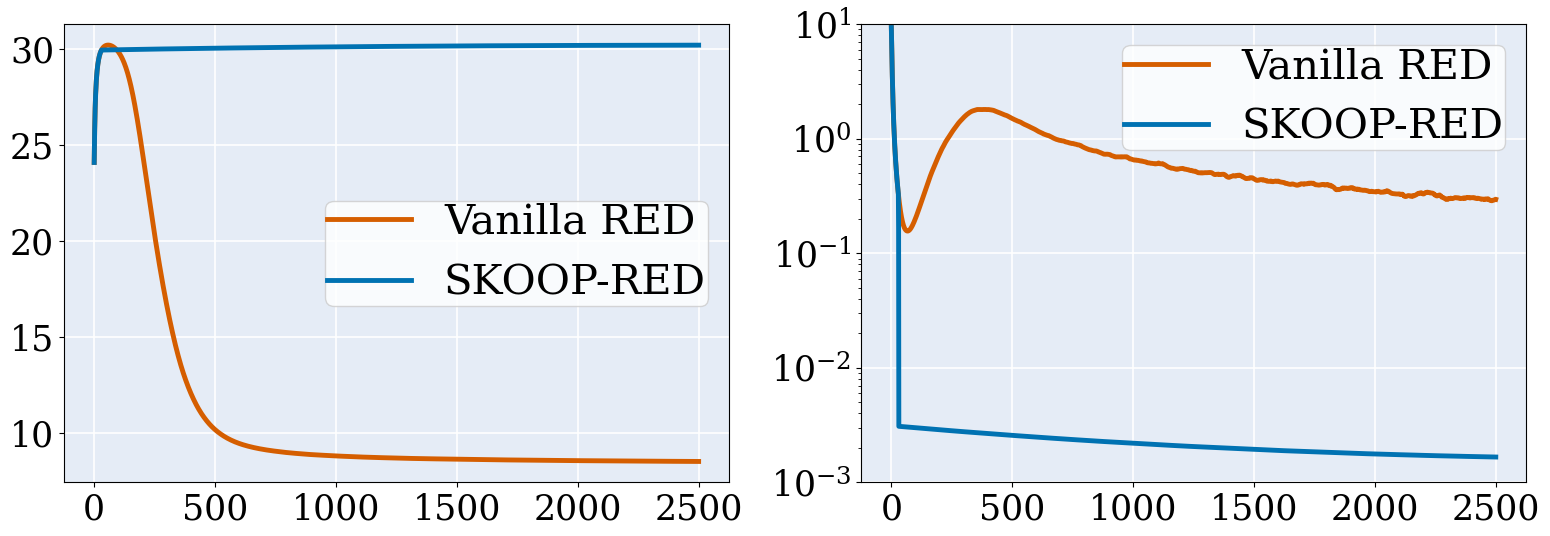

Runtime SKOOP-RED: 57.62s, Vanilla RED: 52.39s
Final PSNRs: Vanilla 8.51, Skoop-RED 30.22
Final SSIMs: Vanilla 0.0982, Skoop-RED 0.9266


In [ ]:


# ---- Run experiments ----
start_skoop = time.time()
skoop = skoop_red_paper(
    y_noisy, denoiser, sr_forward, sr_adjoint, lam, gamma_init, gamma_min,
    koopman_window, koopman_every, iterations,
    beta_paper=2.0, ridge_alpha=1e-6, img_np=img_np
)

runtime_skoop = time.time() - start_skoop

start_vanilla = time.time()
van_psnr, van_ssim, van_norm, van_img, vanilla_snapshots, vanilla_peak = vanilla_red(
    y_noisy, denoiser, sr_forward, sr_adjoint, lam, gamma_init, iterations, img_np
)
runtime_vanilla = time.time() - start_vanilla


# ---- Visualizations  ----

fig, axs = plt.subplots(1, 2, figsize=(16, 6))
for ax in axs:
    ax.set_facecolor('#e5ecf6')
    ax.grid(True, linestyle='-', linewidth=1.2, color='white')
    ax.set_axisbelow(True)

axs[0].plot(van_psnr, label='Vanilla RED', color='#D55E00')
axs[0].plot(skoop['psnr'], label=r'SKOOP-RED', color='#0072B2')
axs[0].legend(loc='center right', borderpad=0.05)

axs[1].plot(van_norm[1:], label='Vanilla RED', color='#D55E00')
axs[1].plot(skoop['norm'][1:], label=r'SKOOP-RED', color='#0072B2')
axs[1].set_yscale('log')
axs[1].set_ylim(1e-3, 10)
axs[1].legend(loc='upper right', borderpad=0.05)

plt.tight_layout()
plt.savefig('RED_num_SR_G1.pdf')
plt.show()

# Runtime final prints
print(f"Runtime SKOOP-RED: {runtime_skoop:.2f}s, Vanilla RED: {runtime_vanilla:.2f}s")
print(f"Final PSNRs: Vanilla {van_psnr[-1]:.2f}, Skoop-RED {skoop['psnr'][-1]:.2f}")
print(f"Final SSIMs: Vanilla {van_ssim[-1]:.4f}, Skoop-RED {skoop['ssim'][-1]:.4f}")

